In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from qiskit import QuantumCircuit, Aer
from qiskit.aqua import QuantumInstance

from vqa_poisson import VQAforPoisson

## Experiments

In [3]:
def experiment(bc, num_trials, num_qubits_list, num_layers, qins):
    
    print('-----------'+bc+' boundary condition --------------')
    
    data = {'num_qubits':[], 'obj_count':[], 'circ_count':[], 'iter_count':[], 'err':[], 'params':[], 'q_sol':[], 'cl_sol':[]}
    
    for num_qubits in tqdm(num_qubits_list):
        print('-------------------------')
        print('num_qubits:', num_qubits)
        
        # set oracle for f vector
        oracle_f = QuantumCircuit(num_qubits)
        oracle_f.x(num_qubits-1)
        oracle_f.h(oracle_f.qubits)
    
        # set vqa instance
        vqa = VQAforPoisson(num_qubits, num_layers, bc, oracle_f=oracle_f, qinstance=qins)

        obj_counts = []
        circ_counts = []
        iter_counts = []
        err = []
        params = []
        q_sol = []
    
        for seed in range(num_trials):
        
            np.random.seed(seed)
        
            x0 = list(4*np.pi*np.random.rand(vqa.num_params))
            res = vqa.minimize(x0, method='bfgs', save_logs=True)
    
            obj_counts.append(vqa.objective_counts)
            circ_counts.append(vqa.circuit_counts)
            iter_counts.append(len(vqa.objective_count_logs))
            err.append(vqa.get_errors(res['x'])['trace'])
            params.append(res['x'])
            q_sol.append(vqa.get_sol(res['x']).real)
            
            print('trial:', seed, 'Err.:', err[-1])
        
        data['num_qubits'].append(num_qubits)
        data['obj_count'].append(obj_counts)
        data['circ_count'].append(circ_counts)
        data['iter_count'].append(iter_counts)
        data['err'].append(err)
        data['params'].append(params)
        data['q_sol'].append(q_sol)
        data['cl_sol'].append(vqa.get_cl_sol().real)
        
    return data

In [4]:
t0 = time.time()
optimizer = 'bfgs'
num_layers = 5
num_trials = 1
num_qubits_list = [4]
qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42)

# bc: Periodic
data_p = experiment('Periodic', num_trials, num_qubits_list, num_layers, qins)

-----------Periodic boundary condition --------------


  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------
num_qubits: 4
It.: 00001, Obj.: -5.358546e-01
It.: 00002, Obj.: -5.371640e-01
It.: 00003, Obj.: -1.001395e+00
It.: 00004, Obj.: -1.129215e+00
It.: 00005, Obj.: -1.308528e+00
It.: 00006, Obj.: -1.634538e+00
It.: 00007, Obj.: -2.002391e+00
It.: 00008, Obj.: -2.094894e+00
It.: 00009, Obj.: -2.242984e+00
It.: 00010, Obj.: -2.456715e+00
It.: 00011, Obj.: -2.545304e+00
It.: 00012, Obj.: -2.589597e+00
It.: 00013, Obj.: -2.622455e+00
It.: 00014, Obj.: -2.671990e+00
It.: 00015, Obj.: -2.688462e+00
It.: 00016, Obj.: -2.707536e+00
It.: 00017, Obj.: -2.715038e+00
It.: 00018, Obj.: -2.724589e+00
It.: 00019, Obj.: -2.728253e+00
It.: 00020, Obj.: -2.729155e+00
It.: 00021, Obj.: -2.730154e+00
It.: 00022, Obj.: -2.730779e+00
It.: 00023, Obj.: -2.731358e+00
It.: 00024, Obj.: -2.731664e+00
It.: 00025, Obj.: -2.731894e+00
It.: 00026, Obj.: -2.731995e+00
It.: 00027, Obj.: -2.732059e+00
It.: 00028, Obj.: -2.732083e+00
It.: 00029, Obj.: -2.732088e+00
It.: 00030, Obj.: -2.732096e+00


## plots

### distribution of solutions

In [5]:
def plot_solution_vectors(q_sol, cl_sol):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(q_sol, label='quantum', color='black')
    ax.plot(cl_sol, label='classical', color='black', linestyle='dashed')
    ax.legend()
    ax.set_xlabel('Node number')
    ax.set_ylabel('Components of solution')

    cnorm = np.linalg.norm(q_sol)
    qnorm = np.linalg.norm(cl_sol)

    ax.text(0.55, 0.65, 'Norm (quantum) = %.1f'%(qnorm), transform=ax.transAxes)
    ax.text(0.55, 0.55, 'Norm (classical) = %.1f'%(cnorm), transform=ax.transAxes)
    
    return fig, ax

In [6]:
idx1, idx2 = 0, 0

Periodic boundary condition, num_qubits: 4


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Node number', ylabel='Components of solution'>)

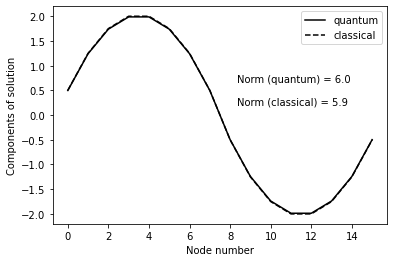

In [7]:
print('Periodic boundary condition, num_qubits:', data_p['num_qubits'][idx1])
q_sol = data_p['q_sol'][idx1][idx2]
cl_sol = data_p['cl_sol'][idx1]
plot_solution_vectors(q_sol, cl_sol)

In [8]:
print('elapsed time: %.2e'%(time.time() - t0))

elapsed time: 1.17e+03
